In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [2]:
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC']

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2019-10-24 16:00:00+00:00,BTCUSDT,7433.2700,7458.0000,7425.0000,7452.7900,2.883884e+03,2.146007e+07,5001.0,1610.465,...,7441.583167,7441.898333,7.469183,3.917731,7444.100333,7438.831167,2.860167,-2.409000,0.000708,6.210302e-07
1,2019-10-23 03:00:00+00:00,BTCUSDT,8034.6000,8034.6100,7937.0000,7953.2000,4.823014e+03,3.845151e+07,8410.0,2247.640,...,7993.990333,7987.906667,32.453367,8.473770,7998.520000,7990.257833,3.147667,-5.114500,0.001035,2.418837e-06
2,2019-10-21 08:00:00+00:00,BTCUSDT,8220.0300,8223.3100,8200.0000,8220.0800,1.884292e+03,1.547155e+07,3148.0,787.277,...,8211.840167,8212.097500,5.155098,2.106208,8213.307667,8210.237333,1.484833,-1.585500,0.000374,1.796818e-07
3,2019-10-22 05:00:00+00:00,BTCUSDT,8213.0000,8216.8600,8200.0000,8209.0500,2.027282e+03,1.663915e+07,2812.0,1085.684,...,8207.827167,8207.930000,2.494095,1.795042,8209.315667,8206.368833,1.596167,-1.350667,0.000359,1.617892e-07
4,2019-10-24 09:00:00+00:00,BTCUSDT,7442.0400,7468.0000,7430.0000,7433.8100,2.686744e+03,2.000874e+07,4527.0,1199.481,...,7446.607500,7444.494167,7.547849,4.973154,7449.926000,7443.901500,2.860667,-3.163833,0.000809,8.151147e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234730,2022-05-03 20:00:00+00:00,MATICUSDT,1.0585,1.0706,1.0553,1.0684,6.300951e+06,6.690385e+06,15622.0,3534712.000,...,1.061267,1.061350,0.002023,0.001429,1.062073,1.060277,0.000993,-0.000803,0.001693,3.968841e-06
234731,2022-04-20 01:00:00+00:00,MATICUSDT,1.4104,1.4510,1.4102,1.4421,1.124620e+07,1.611851e+07,32862.0,6074134.000,...,1.428932,1.429442,0.012843,0.002190,1.430120,1.427342,0.001700,-0.001078,0.001941,5.471737e-06
234732,2022-05-03 04:00:00+00:00,MATICUSDT,1.0904,1.0948,1.0875,1.0922,3.710939e+06,4.050010e+06,12787.0,1938142.000,...,1.090928,1.090700,0.001802,0.000779,1.091538,1.090312,0.000623,-0.000603,0.001124,1.545965e-06
234733,2022-04-29 23:00:00+00:00,MATICUSDT,1.1417,1.1456,1.1368,1.1404,4.201056e+06,4.794202e+06,17085.0,1994714.000,...,1.141455,1.141642,0.002123,0.001098,1.142047,1.140733,0.000572,-0.000742,0.001151,1.792121e-06


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-20 19:00:00+00:00 ETH     1177.63000  1191.00000  1174.6500   
                          LINK       5.98300     6.00000     5.9570   
                          MATIC      0.83260     0.83270     0.8261   
                          SOL       12.77800    12.77900    12.6820   
                          XRP        0.37520     0.37880     0.3749   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-20 19:00:00+00:00 ETH     1184.5000  1.759636e+05  1177.005000   
                          LINK       5.9850  6.649994e+05     5.970167   
                          MATIC      0.8312  1.324654e+07     0.829508   
                          SOL       12.7610  4.696030e+05    12.737917   
                          XRP        0.3773  5.956578e+07     0.376283   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-20 19:00:00+00:00 ETH        False  
                          LINK       False  
                          MATIC      False  
                          SOL        False  
                          XRP        False  

[353413 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [3, 6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from functools import partial

class ExampleModelRank:
    def __init__(self):
        ridge = Ridge(fit_intercept=False, alpha=1e5)
        
        bagging_n = 5
        
        rf = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            # extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf = BaggingRegressor(
            rf,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        rf_clf = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            # extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf_clf = BaggingRegressor(
            rf_clf,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        rf_et = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            bagging_fraction=0.5,
            bagging_freq=3,
            boosting='rf',
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        rf_et = BaggingRegressor(
            rf_et,
            n_estimators=bagging_n,
            # max_samples=0.9,
            # bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        lgbm = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            # colsample_bytree=0.1,
            # reg_lambda=1,
            # subsample=0.5,
            # subsample_freq=1,
            random_state=1,
            n_jobs=-1,
        )
        lgbm = BaggingRegressor(
            lgbm,
            n_estimators=bagging_n,
            max_samples=0.9,
            bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
            
        lgbm_clf = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            extra_trees=True,
            # colsample_bytree=0.9,
            # reg_lambda=1,
            random_state=1,
            n_jobs=-1,
        )
        lgbm_clf = BaggingRegressor(
            lgbm_clf,
            n_estimators=bagging_n,
            max_samples=0.9,
            bootstrap=False,
            # max_features=0.9,
            random_state=1
        )
        
        # self._model = ridge
        # self._model = rf
        # self._model = rf_clf
        # self._model = lgbm
        # self._model = lgbm_clf
        
        self._model = VotingRegressor([
            # ('ridge', ridge),
            ('lgbm', lgbm),
            # ('lgbm_clf', lgbm_clf),
            ('rf', rf),
            ('rf_et', rf_et),
        ],
            # weights=[
            # # 0.2,
            # 1,
            # # 0.5,
            # 1,
            # 1,
            # ]
        )
        
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self.max_data_sec = 14 * 24 * 60 * 60 # for predict script
        self.horizon = 4
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-4) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_train'] = df.groupby('symbol')['ret_train'].transform(lambda x: x - x.iloc[::-1].rolling(24 * 1, 1).mean().iloc[::-1])
        
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        # return self._model.fit(df[features], df['ret_train'])
        return self._model.fit(df[features], np.sign(df['ret_train']), sample_weight=np.abs(df['ret_train']))
        # return self._model.fit(df[features], np.sign(df['ret_train']), model__sample_weight=np.abs(df['ret_train']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['position'] = 0.0
        # for m in self._model.estimators_:
        #     y_pred = m.predict(df[features])
        #     df['position'] = np.sign(y_pred)
        # df['position'] /= len(self._model.estimators_)
        
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        
        # df['position'] -= df['position'].rolling(24 * 1, 1).mean()
        
        # df['position'] = y_pred
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.2))
        
        # normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        # df = calc_features_single(df)
        # return df
        
        df['ln_hilo'] = 0.5 * (np.log(df['hi']) + np.log(df['lo']))
        df['ln_hilocl'] = (np.log(df['hi']) + np.log(df['lo']) + np.log(df['cl'])) / 3
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
        df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
        
        t = df.index.get_level_values('timestamp')
        df['t'] = t.dayofweek * 24 + t.hour
        
        # assume single symbol
        df.loc[df['t'] == 0, 'cl_monday_op'] = df.loc[df['t'] == 0, 'cl']
        df['cl_monday_op'] = df['cl_monday_op'].ffill().fillna(df['cl'])
        # df.loc[df['t'] == 0, 'cl_monday_op'] = df.loc[df['t'] == 0, 'twap_5m']
        # df['cl_monday_op'] = df['cl_monday_op'].ffill().fillna(df['twap_5m'])
        
        df.loc[df['t'] == 24 * 6, 'cl_sunday_op'] = df.loc[df['t'] == 24 * 6, 'cl']
        df['cl_sunday_op'] = df['cl_sunday_op'].ffill().fillna(df['cl'])
        # df.loc[df['t'] == 24 * 6, 'cl_sunday_op'] = df.loc[df['t'] == 24 * 6, 'twap_5m']
        # df['cl_sunday_op'] = df['cl_sunday_op'].ffill().fillna(df['twap_5m'])
        
        def stoch(x, t):
            hi = x.rolling(t, 1).max()
            lo = x.rolling(t, 1).min()
            mid = (hi + lo) / 2
            rg = (hi - lo) / 2
            return (x - mid) / (1e-37 + rg)
        
        def sunday(x):
            t = x.index.get_level_values('timestamp')
            dow = t.dayofweek
            cl_monday_op = df.loc[x.index, 'cl_monday_op']
            cl_sunday_op = df.loc[x.index, 'cl_sunday_op']
            
            return np.where(dow == 6, cl_sunday_op / cl_monday_op - 1, 0)
        
        df['feature_sunday'] = df.groupby('symbol')['cl'].transform(sunday)
        
        # df['feature_dayofweek'] = t.dayofweek
        # for i in range(7):
        # for i in [6]:
        #     df['feature_dayofweek_{}'.format(i)] = (t.dayofweek == i) * 1.0
        
        for i in [24]:
            # df['feature_prev_{}'.format(i)] = (df.groupby('symbol')['cl'].shift(i) / df.groupby('symbol')['cl'].shift(i + 4) - 1).fillna(0)
            df['feature_prev_{}'.format(i)] = (df.groupby('symbol')['twap_5m'].shift(i - 5) / df.groupby('symbol')['twap_5m'].shift(i - 1) - 1).fillna(0)
        
        for i in [1, 2, 4, 8, 24, 48, 72, 168]:
            # df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
            df['feature_momentum_{}'.format(i)] = (df['twap_5m'] / df.groupby('symbol')['twap_5m'].shift(i) - 1).fillna(0)
            # df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['twap_5m'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72, 168]:
        # for i in [3, 5, 11, 29, 53, 73]:
        # for i in [2, 4, 8, 24, 48, 72] + [3, 5, 11, 29, 53, 73]:
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['twap_5m'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))
            
            # df['feature_stoch_{}'.format(i)] = df.groupby('symbol')['cl'].transform(partial(stoch, t=i))

        # symbol_count = df.reset_index()['symbol'].unique().size
    
        # for col in get_feature_columns(df):
        #     df[col + '_rr'] = df.groupby('symbol')[col].transform(lambda x: x.rolling(1000, 1).rank(pct=True) - 0.5)
        # #     # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # #     # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
        # #     # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))
        #     df = df.drop(columns=col)
            
        return df

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.001606994478305476
std 0.025607545957876073
sharpe 0.06275472397663374
double sharpe 1.099444351140906
max drawdown 2.7771698803044274
min -0.4734457465437224
min sharpe 0.003394252646764609
return with cost statistics
mean 0.001356961370107906
std 0.025609879160649277
sharpe 0.052985856028283713
double sharpe 0.8437285283086006
max drawdown 3.5451872014689485
min -0.4742457465437224
min sharpe 0.002861304249953463


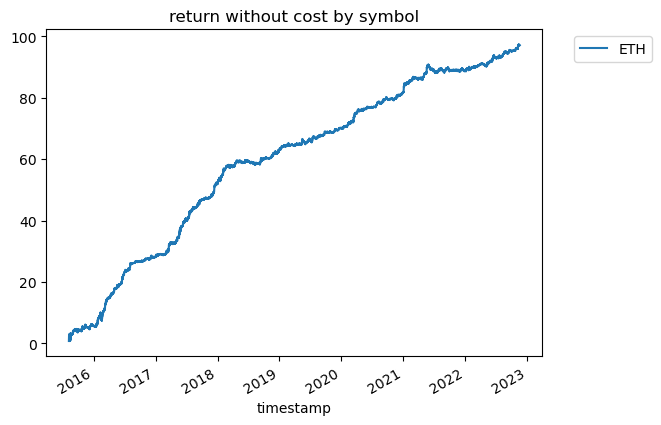

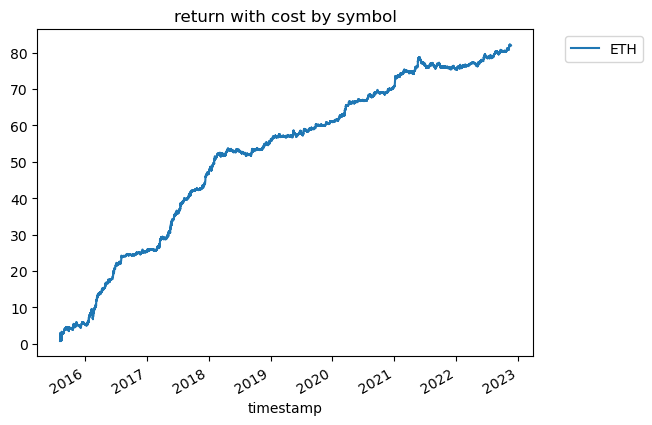

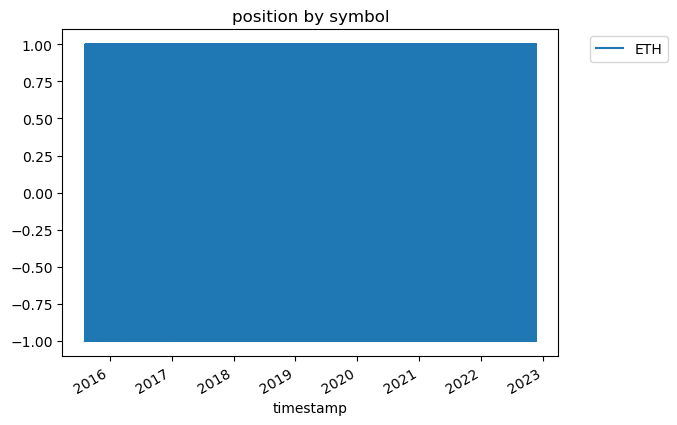

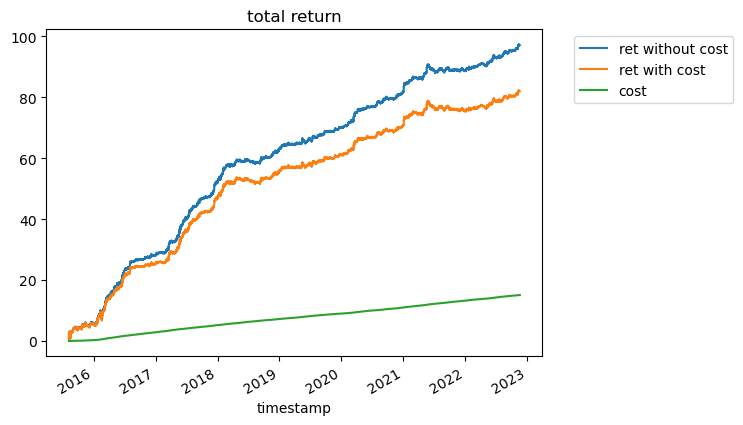

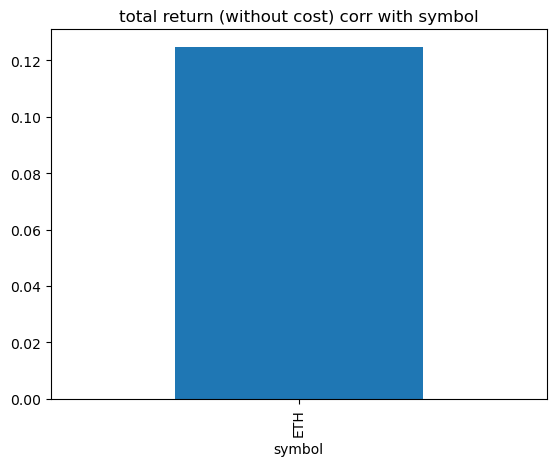

return without cost statistics
mean 0.0010491027674434663
std 0.019396730857449654
sharpe 0.05408657650371738
double sharpe 0.8901594282453891
max drawdown 2.777169880304452
min -0.21113066800771096
min sharpe 0.004968973846116713
return with cost statistics
mean 0.0008100427192211926
std 0.019394484871744912
sharpe 0.041766652972635175
double sharpe 0.6405876659529952
max drawdown 3.5451872014689947
min -0.21193066800771096
min sharpe 0.003822206228273294


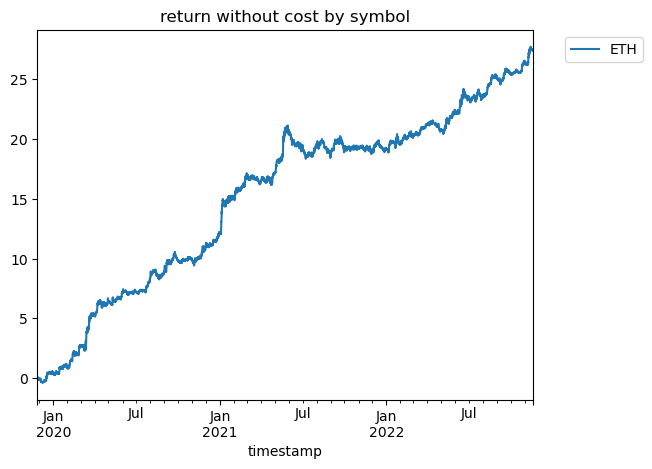

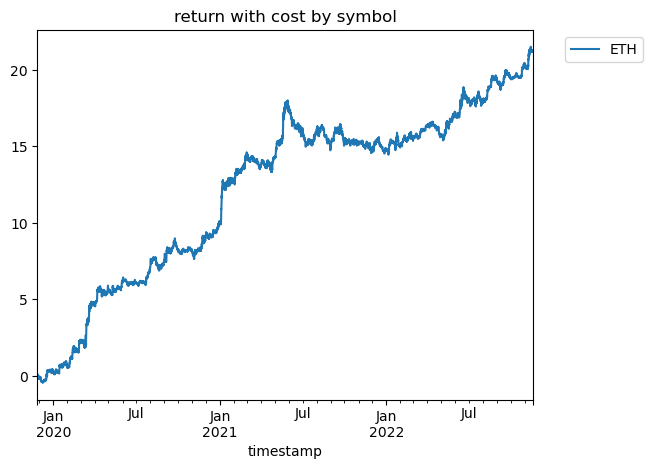

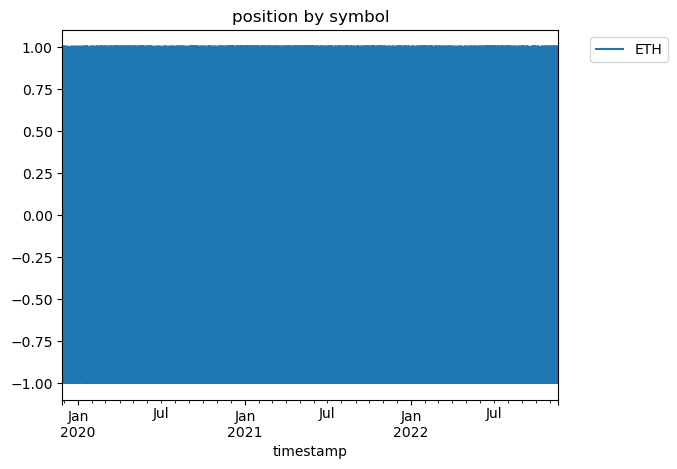

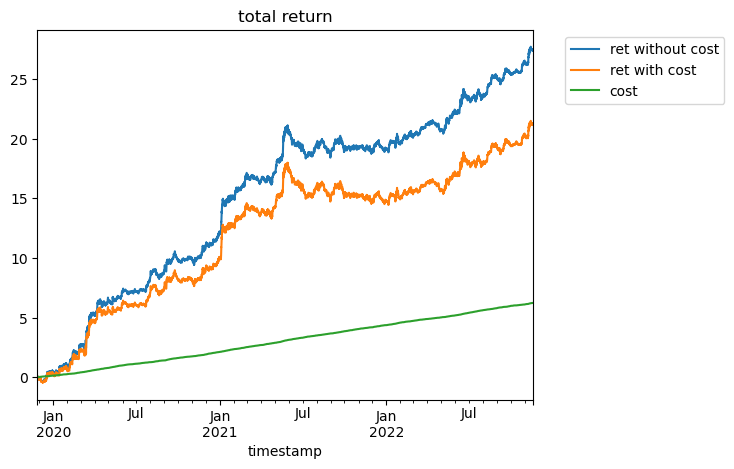

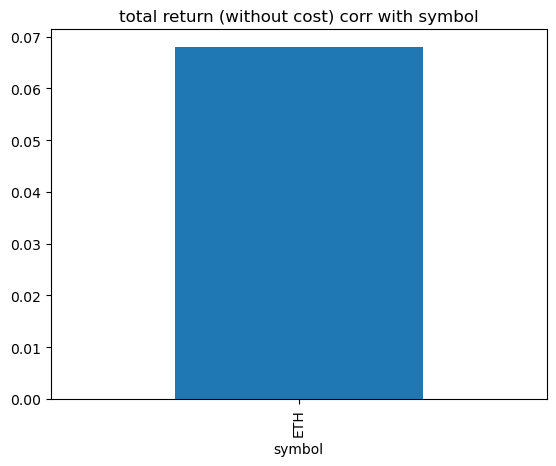

In [5]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
# df = df.loc[df.index.get_level_values('symbol') == 'BTC']
df = df.loc[df.index.get_level_values('symbol') == 'ETH'] # good
# df = df.loc[df.index.get_level_values('symbol') == 'BNB']
# df = df.loc[df.index.get_level_values('symbol') == 'XRP']
# df = df.loc[df.index.get_level_values('symbol') == 'ATOM'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'LINK']
# df = df.loc[df.index.get_level_values('symbol') == 'DOT']
# df = df.loc[df.index.get_level_values('symbol') == 'MATIC'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'SOL'] # good without cost
# df = df.loc[df.index.get_level_values('symbol') == 'ADA']
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-20 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2019-08-01 00:00:00Z')]
df = df.copy()

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-5) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
# visualize_result(df.dropna(), execution_cost=0.0004)
visualize_result(df.dropna(), execution_cost=0.0004, horizon=4)
# visualize_result(df.dropna(), execution_cost=0.001)
visualize_result(df.loc[~df['extended']].dropna(), execution_cost=0.0004, horizon=4)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220921_eth.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-11-06 19:00:00+00:00  ETH      -1.0
2022-11-06 20:00:00+00:00  ETH      -1.0
2022-11-06 21:00:00+00:00  ETH      -1.0
2022-11-06 22:00:00+00:00  ETH      -1.0
2022-11-06 23:00:00+00:00  ETH      -1.0
                                    ... 
2022-11-20 15:00:00+00:00  ETH      -1.0
2022-11-20 16:00:00+00:00  ETH      -1.0
2022-11-20 17:00:00+00:00  ETH      -1.0
2022-11-20 18:00:00+00:00  ETH      -1.0
2022-11-20 19:00:00+00:00  ETH      -1.0
Name: position, Length: 337, dtype: float64
['ETH']
test shift predict


,,position1,position2,position3
timestamp,symbol,,,
2022-11-06 20:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-06 21:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-06 22:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-06 23:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-07 00:00:00+00:00,ETH,-1.0,-1.0,-1.0
...,...,...,...,...
2022-11-20 14:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-20 15:00:00+00:00,ETH,-1.0,-1.0,-1.0
2022-11-20 16:00:00+00:00,ETH,-1.0,-1.0,-1.0


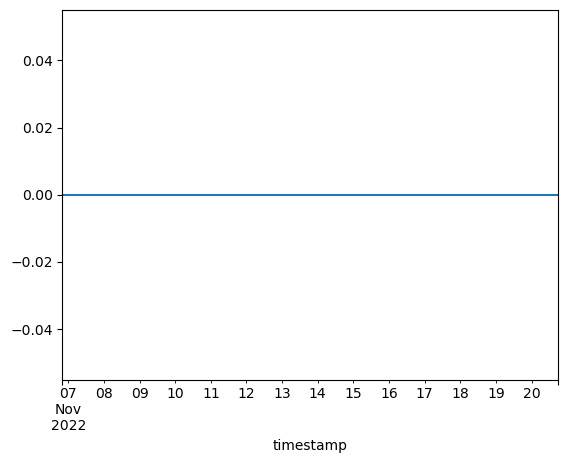

ETH (335, 4)


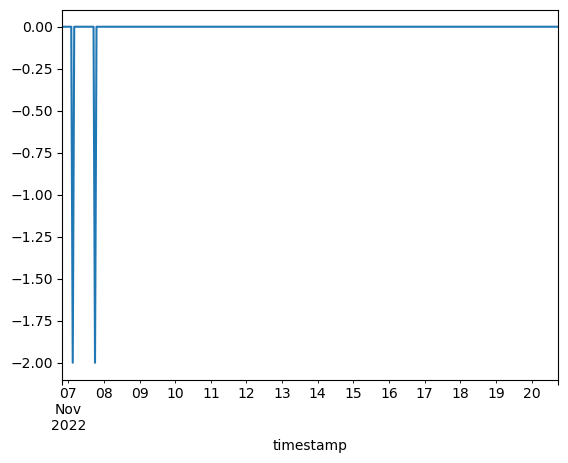

ETH (337, 3)


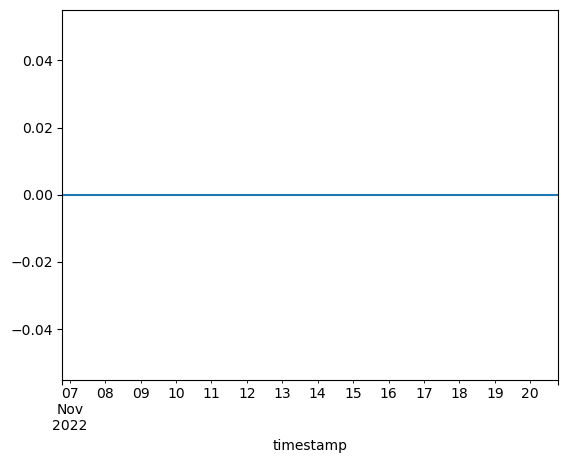

In [6]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220921_eth.xz')
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('symbol') == 'ETH']
df = df[['op', 'hi', 'lo', 'cl', 'twap_5m']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()